## Module 2: PSF Generation with Aberrations

### Purpose
Create time-varying PSFs that encode both static telescope aberrations and dynamic variations, representing the optical quality we're trying to constrain.

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import hcipy

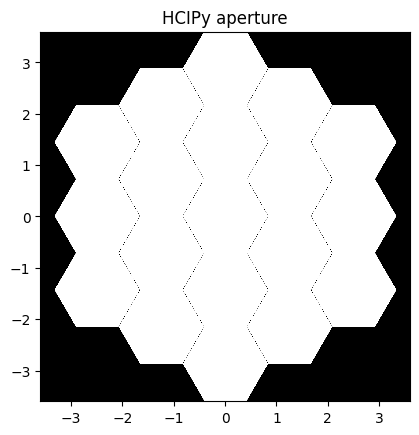

In [13]:
# Parameters for the pupil function
gap_size = 5e-3 # m
segment_point_to_point = 1.65814999 # m

pupil_diameter = 7.2 # m
num_rings = 2
segment_flat_to_flat = segment_point_to_point * np.sqrt(3) / 2
focal_length = 191.861 # m

# Parameters for the simulation
num_pix = 2048
wavelength = 400e-9
num_airy = 20
sampling = 6
norm = False

# HCIPy grids and propagator
pupil_grid = hcipy.make_pupil_grid(dims=num_pix, diameter=pupil_diameter)

focal_grid = hcipy.make_focal_grid(sampling, num_airy,
                                   pupil_diameter=pupil_diameter,
                                   reference_wavelength=wavelength,
                                   focal_length=focal_length)
focal_grid = focal_grid.shifted(focal_grid.delta / 2)

prop = hcipy.FraunhoferPropagator(pupil_grid, focal_grid, focal_length)

aper, segments = hcipy.make_hexagonal_segmented_aperture(num_rings,
                                                         segment_flat_to_flat,
                                                         gap_size,
                                                         starting_ring=0,
                                                         return_segments=True)

supersampling_factor = 8
aper = hcipy.evaluate_supersampled(aper, pupil_grid, supersampling_factor)
segments = hcipy.evaluate_supersampled(segments, pupil_grid, supersampling_factor)

plt.title('HCIPy aperture')
hcipy.imshow_field(aper, cmap='gray')

In [14]:
# Instantiate the segmented mirror
hsm = hcipy.SegmentedDeformableMirror(segments)

# Make a pupil plane wavefront from aperture
wf = hcipy.Wavefront(aper, wavelength)

# Apply SM if you want to
wf = hsm(wf)

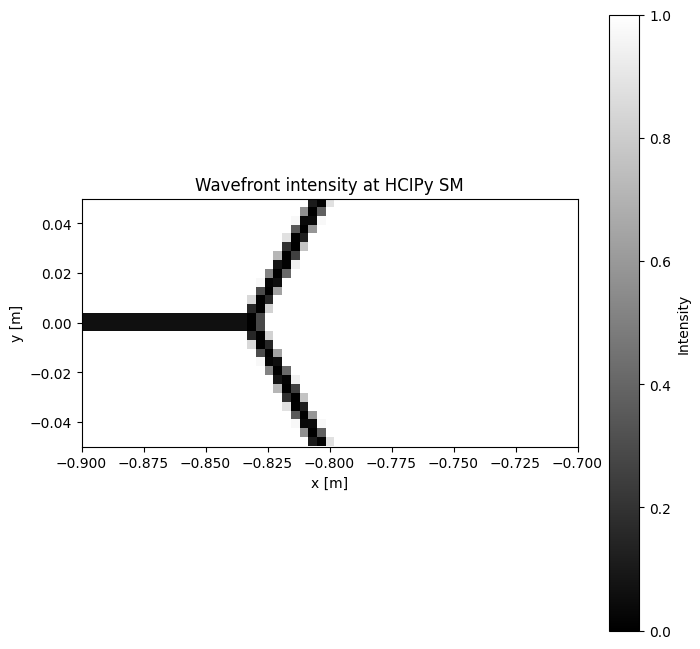

In [15]:
plt.figure(figsize=(8, 8))
plt.title('Wavefront intensity at HCIPy SM')

# Get the grid coordinates
x = pupil_grid.coords[0]
y = pupil_grid.coords[1]

# Define zoom region:
zoom_xmin, zoom_xmax = -.9, -0.7
zoom_ymin, zoom_ymax = -0.05, 0.05

# Mask for the zoomed region
zoom_mask = (x >= zoom_xmin) & (x <= zoom_xmax) & (y >= zoom_ymin) & (y <= zoom_ymax)

# Create a zoomed field for pixel-based visualization
# First, create a subgrid for the zoom region
zoom_indices = np.where(zoom_mask.reshape(pupil_grid.shape))
y_indices, x_indices = zoom_indices

# Get the bounds of the zoom region in grid indices
y_min, y_max = y_indices.min(), y_indices.max() + 1
x_min, x_max = x_indices.min(), x_indices.max() + 1

# Extract the zoomed intensity as a 2D array
zoom_intensity_2d = wf.intensity.shaped[y_min:y_max, x_min:x_max]

# Create extent for proper axis scaling
extent = [zoom_xmin, zoom_xmax, zoom_ymin, zoom_ymax]

# Plot using imshow with nearest neighbor interpolation to show discrete pixels
plt.imshow(zoom_intensity_2d, cmap='gray', interpolation='nearest', 
           extent=extent, origin='lower', aspect='equal')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.colorbar(label='Intensity')
plt.show()

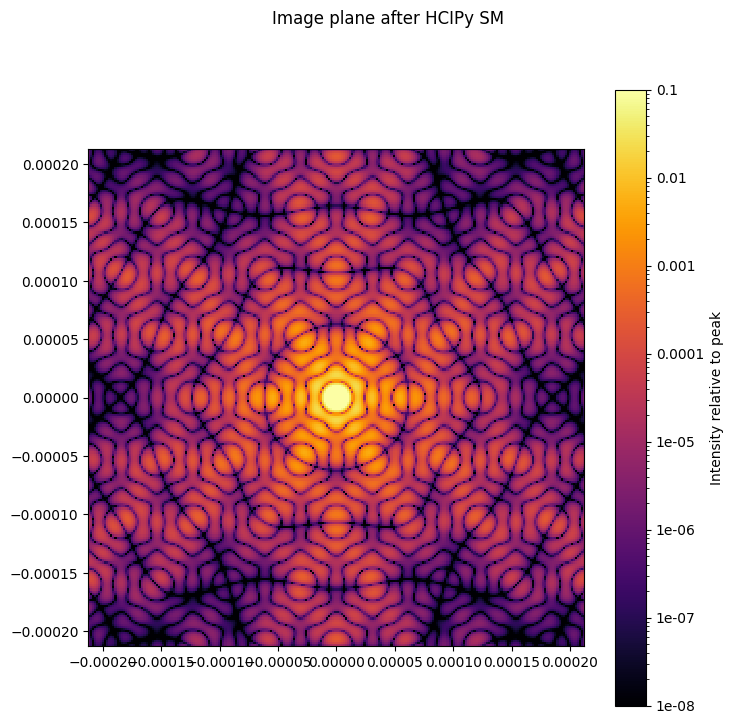

In [16]:
# Apply SM to pupil plane wf
wf_sm = hsm(wf)

# Propagate from SM to image plane
im_ref_hc = prop(wf)

# Display intensity and phase in image plane
plt.figure(figsize=(8, 8))
plt.suptitle('Image plane after HCIPy SM')

# Get normalization factor for HCIPy reference image
norm_hc = np.max(im_ref_hc.intensity)

hcipy.imshow_psf(im_ref_hc, normalization='peak')

### Aberrations
Segment tip/tilt
Segment piston
Total mirror wavefront (Zernike)

In [17]:
# Cell 1: Define the segment mode basis functions from telescope.py

def make_hexike_basis(num_modes, circum_diameter, grid, hexagon_angle=0):
    """Make a hexike basis.
    
    This is based on [Mahajan2006]_. This function creates a Zernike mode basis and
    numerically orthogonalizes it using Gramm-Schmidt orthogonalization.
    
    .. [Mahajan2006] Virendra N. Mahajan and Guang-ming Dai,
        "Orthonormal polynomials for hexagonal pupils," Opt.
        Lett. 31, 2462-2464 (2006)
    
    Parameters
    ----------
    num_modes : int
        The number of hexike modes to compute.
    circum_diameter : float
        The circumdiameter of the hexagonal aperture.
    grid : hcipy.Grid
        The grid on which to compute the mode basis.
    hexagon_angle : float, optional
        The rotation angle of the hexagon in radians. Default is 0.
    
    Returns
    -------
    hcipy.ModeBasis
        The hexike mode basis.
    """
    zernike_basis = hcipy.make_zernike_basis(int(num_modes), circum_diameter, grid)
    # Create hexagonal aperture for this basis
    hexagonal_aperture = hcipy.make_hexagonal_aperture(circum_diameter, hexagon_angle)(grid)
    sqrt_weights = np.sqrt(grid.weights)
    
    if np.isscalar(sqrt_weights):
        sqrt_weights = np.array([sqrt_weights])
    
    # Un-normalize the zernike modes using the weights of the grid.
    # Reshape to properly broadcast: (n_pixels,) -> (n_pixels, 1)
    weights_factor = (hexagonal_aperture * sqrt_weights)[:, np.newaxis]
    zernike_basis.transformation_matrix *= weights_factor
    
    # Perform Gramm-Schmidt orthogonalization using a QR decomposition.
    Q, R = np.linalg.qr(zernike_basis.transformation_matrix)
    
    # Correct for negative sign of components of the Q matrix.
    hexike_basis = hcipy.ModeBasis(Q / np.sign(np.diag(R)), grid)
    
    # Renormalize the resulting functions using the area of a hexagon and the grid weights.
    area_hexagon = 3 * np.sqrt(3) / 8 * circum_diameter**2
    # Reshape sqrt_weights for proper broadcasting
    normalization_factor = (np.sqrt(area_hexagon) / sqrt_weights)[:, np.newaxis]
    hexike_basis.transformation_matrix *= normalization_factor
    
    return hexike_basis

def make_segment_modes(segments, segment_centers, segment_diameter, pupil_grid, 
                       num_modes_per_segment, pointy_top=False):
    """Make a list of modes containing segment-level modes for each segment.
    
    Parameters
    ----------
    segments : list of hcipy.Field
        List of segment apertures.
    segment_centers : hcipy.Grid
        Grid containing the center positions of each segment.
    segment_diameter : float
        The circumscribed diameter of each hexagonal segment.
    pupil_grid : hcipy.Grid
        The pupil grid.
    num_modes_per_segment : int
        The number of modes per segment.
    pointy_top : bool, optional
        Whether the hexagons have a pointy top. Default is False (flat top).
    
    Returns
    -------
    list of ndarray
        A list of computed modes, normalized to RMS=1 over each segment.
    """
    modes = []
    angle = 0 if pointy_top else np.pi / 2
    
    for i, center in enumerate(segment_centers.points):
        # Create hexike basis shifted to segment center
        basis = make_hexike_basis(num_modes_per_segment, segment_diameter, 
                                  pupil_grid.shifted(-center), angle)
        
        # Extract the modes and normalize them over the segment
        for mode in basis:
            mode_array = np.asarray(mode.shaped)
            segment_mask = segments[i].shaped
            
            # Normalize to RMS=1 over the segment
            mode_over_segment = mode_array * segment_mask
            rms = np.sqrt(np.mean(mode_over_segment[segment_mask > 0.5]**2))
            if rms > 0:
                mode_array /= rms
            
            modes.append(mode_array)
    
    return modes

In [18]:
# Cell 2: Define all aberration functions

# Helper functions
def nm_to_opd(nm_rms):
    return nm_rms * 1e-9

def urad_to_rad(urad):
    return urad * 1e-6

# Get correct segment count
num_segments = len(segments)

# Aberration 1: Segment Piston Errors
def apply_segment_pistons(hsm, piston_dict, wavelength=wavelength):
    """Apply piston errors to individual segments.
    
    Parameters
    ----------
    hsm : hcipy.SegmentedDeformableMirror
        The segmented mirror object.
    piston_dict : dict
        Dictionary mapping segment ID to piston values in nm.
    wavelength : float
        Wavelength in meters.
    """
    hsm.flatten()
    for seg_id, piston_nm in piston_dict.items():
        if seg_id < num_segments:
            piston_m = nm_to_opd(piston_nm) / 2  # Factor of 2 for reflection
            hsm.set_segment_actuators(seg_id, piston_m, 0, 0)

# Aberration 2: Segment Tip/Tilt Errors
def apply_segment_tiptilts(hsm, tiptilt_dict):
    """Apply tip/tilt errors to individual segments.
    
    Parameters
    ----------
    hsm : hcipy.SegmentedDeformableMirror
        The segmented mirror object.
    tiptilt_dict : dict
        Dictionary mapping segment ID to (tip_urad, tilt_urad) tuples.
    """
    for seg_id, (tip_urad, tilt_urad) in tiptilt_dict.items():
        if seg_id < num_segments:
            current_piston = hsm.actuators[seg_id * 3]
            tip_rad = urad_to_rad(tip_urad) / 2  # Factor of 2 for reflection
            tilt_rad = urad_to_rad(tilt_urad) / 2
            hsm.set_segment_actuators(seg_id, current_piston, tip_rad, tilt_rad)

# Aberration 3: Segment Zernike Errors (OPTIMIZED)
def apply_segment_zernikes(segment_zernike_dict, wavelength=wavelength):
    """Apply Zernike aberrations to individual segments (optimized version).
    
    Parameters
    ----------
    segment_zernike_dict : dict
        Dictionary mapping segment ID to another dict of {mode: amplitude_nm}.
        Example: {0: {4: 20, 5: 10}, 5: {6: 15}} applies Z4=20nm and Z5=10nm
        to segment 0, and Z6=15nm to segment 5.
    wavelength : float
        Wavelength in meters.
    
    Returns
    -------
    phase_screen : hcipy.Field
        Phase screen containing segment-level Zernike aberrations.
    """
    # Calculate segment centers
    segment_pitch = segment_flat_to_flat + gap_size
    segment_centers = hcipy.make_hexagonal_grid(segment_pitch, num_rings, False)
    mask = segment_centers.ones(dtype='bool')
    segment_centers_grid = segment_centers.subset(mask)
    
    # The segment diameter is the circumscribed diameter (vertex-to-vertex)
    segment_diameter = segment_point_to_point
    
    # Initialize phase screen
    phase_screen = pupil_grid.zeros()
    
    # Process each segment that has aberrations
    for seg_id, mode_dict in segment_zernike_dict.items():
        if seg_id < num_segments:
            # Get the center of this segment
            center = segment_centers_grid.points[seg_id]
            
            # Find the maximum mode needed for this segment
            max_mode_for_segment = max(mode_dict.keys())
            
            # Create hexike basis for this segment only
            angle = np.pi / 2  # For flat-top hexagons
            basis = make_hexike_basis(int(max_mode_for_segment + 1), segment_diameter,
                                      pupil_grid.shifted(-center), angle)
            
            # Apply each requested mode
            for mode, coeff_nm in mode_dict.items():
                if mode < len(basis):
                    phase_rad = 2 * np.pi * nm_to_opd(coeff_nm) / wavelength
                    # Get the mode as a Field (already 1D)
                    mode_field = basis[mode]
                    # Apply segment mask to ensure mode only affects this segment
                    segment_mask = segments[seg_id]
                    phase_screen += phase_rad * mode_field * segment_mask
    
    return phase_screen

# Aberration 4: Global Zernike Errors
num_zernike_modes = 50
pupil_diameter_for_zernike = pupil_grid.x.max() - pupil_grid.x.min()
zernike_basis = hcipy.make_zernike_basis(num_zernike_modes, D=pupil_diameter_for_zernike, grid=pupil_grid)

def apply_global_zernikes(zernike_coeffs_nm, zernike_basis, wavelength=wavelength):
    phase_screen = pupil_grid.zeros()
    
    if isinstance(zernike_coeffs_nm, dict):
        for mode, coeff_nm in zernike_coeffs_nm.items():
            if mode < len(zernike_basis):
                phase_rad = 2 * np.pi * nm_to_opd(coeff_nm) / wavelength
                phase_screen += phase_rad * zernike_basis[mode]
    else:
        for mode, coeff_nm in enumerate(zernike_coeffs_nm):
            if coeff_nm != 0 and mode < len(zernike_basis):
                phase_rad = 2 * np.pi * nm_to_opd(coeff_nm) / wavelength
                phase_screen += phase_rad * zernike_basis[mode]
    
    return phase_screen

In [19]:
# Cell 3: Main PSF generation function
def generate_aberrated_psf(segment_pistons=None, segment_tiptilts=None,
                           segment_zernikes=None, zernike_coeffs=None,
                           return_all=False):
    """Generate a PSF with various aberrations.
    
    Parameters
    ----------
    segment_pistons : dict, optional
        Dictionary mapping segment ID to piston values in nm.
    segment_tiptilts : dict, optional
        Dictionary mapping segment ID to (tip_urad, tilt_urad) tuples.
    segment_zernikes : dict, optional
        Dictionary mapping segment ID to {mode: amplitude_nm} dicts.
    zernike_coeffs : dict or array_like, optional
        Global Zernike coefficients in nm RMS.
    return_all : bool
        If True, return PSF, wavefront, and phase screens.
    
    Returns
    -------
    psf : hcipy.Field
        The aberrated PSF.
    wf : hcipy.Wavefront, optional
        The aberrated wavefront (if return_all=True).
    phase_screens : dict, optional
        Dictionary of phase screens (if return_all=True).
    """
    hsm.flatten()
    
    # Apply segment-level aberrations in order
    if segment_pistons:
        apply_segment_pistons(hsm, segment_pistons)
    
    if segment_tiptilts:
        apply_segment_tiptilts(hsm, segment_tiptilts)
    
    # Create wavefront and apply segmented mirror
    wf = hcipy.Wavefront(aper, wavelength)
    wf = hsm(wf)
    
    # Track phase screens for diagnostics
    phase_screens = {}
    
    # Apply segment-level Zernike aberrations
    if segment_zernikes:
        segment_phase_screen = apply_segment_zernikes(segment_zernikes)
        wf.electric_field *= np.exp(1j * segment_phase_screen)
        phase_screens['segment_zernikes'] = segment_phase_screen
    
    # Apply global Zernike aberrations
    if zernike_coeffs:
        global_phase_screen = apply_global_zernikes(zernike_coeffs, zernike_basis, wavelength)
        wf.electric_field *= np.exp(1j * global_phase_screen)
        phase_screens['global_zernikes'] = global_phase_screen
    
    # Propagate to focal plane
    psf = prop(wf)
    
    if return_all:
        return psf, wf, phase_screens
    return psf

=== Example 1: Segment Piston Errors ===


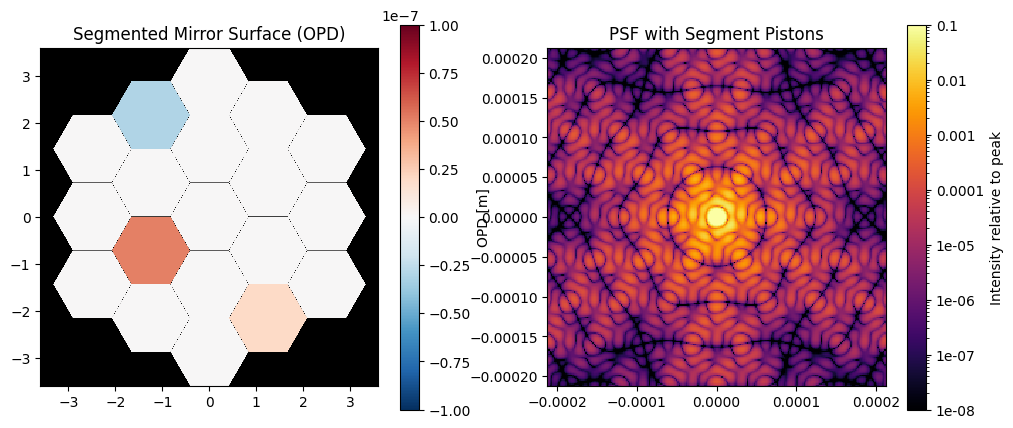

In [20]:
# Aberration 1: Pure segment piston errors
print("=== Example 1: Segment Piston Errors ===")
segment_pistons = {
    5: 50,    # 50 nm piston on segment 5
    12: -30,  # -30 nm piston on segment 12
    18: 20    # 20 nm piston on segment 18
}

psf_piston = generate_aberrated_psf(segment_pistons=segment_pistons)

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.title('Segmented Mirror Surface (OPD)')
hcipy.imshow_field(hsm.surface * 2, mask=aper, cmap='RdBu_r', 
                   vmin=-100e-9, vmax=100e-9)
plt.colorbar(label='OPD [m]')

plt.subplot(122)
plt.title('PSF with Segment Pistons')
hcipy.imshow_psf(psf_piston, normalization='peak')
plt.show()


=== Example 2: Segment Tip/Tilt Errors ===


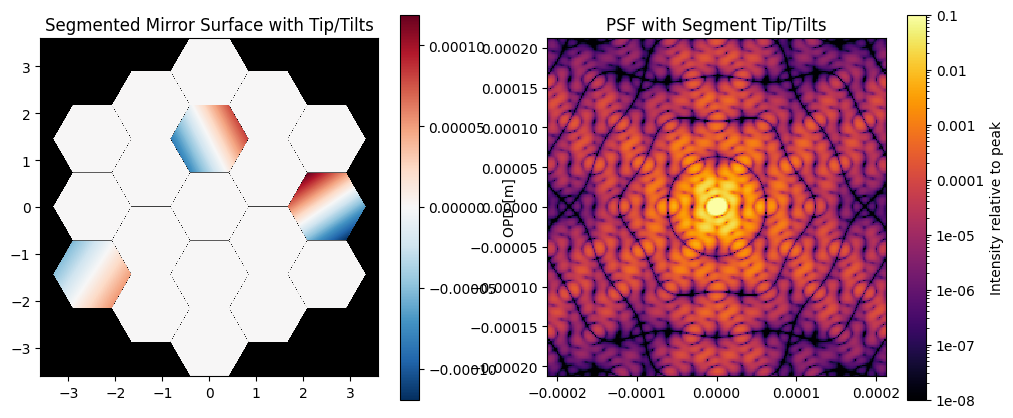

In [21]:
# Example 2: Segment tip/tilt errors
print("\n=== Example 2: Segment Tip/Tilt Errors ===")
hsm.flatten()  # Reset first

segment_tiptilts = {
    3: (100, 50),   # 100 μrad tip, 50 μrad tilt
    8: (-80, 120),  # -80 μrad tip, 120 μrad tilt
    15: (60, -40)   # 60 μrad tip, -40 μrad tilt
}

psf_tiptilt = generate_aberrated_psf(segment_tiptilts=segment_tiptilts)

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.title('Segmented Mirror Surface with Tip/Tilts')
hcipy.imshow_field(hsm.surface * 2, mask=aper, cmap='RdBu_r')
plt.colorbar(label='OPD [m]')

plt.subplot(122)
plt.title('PSF with Segment Tip/Tilts')
hcipy.imshow_psf(psf_tiptilt, normalization='peak')
plt.show()

## API Segment Testing


=== Example 3: Segment-Level Hexike Aberrations (New API) ===


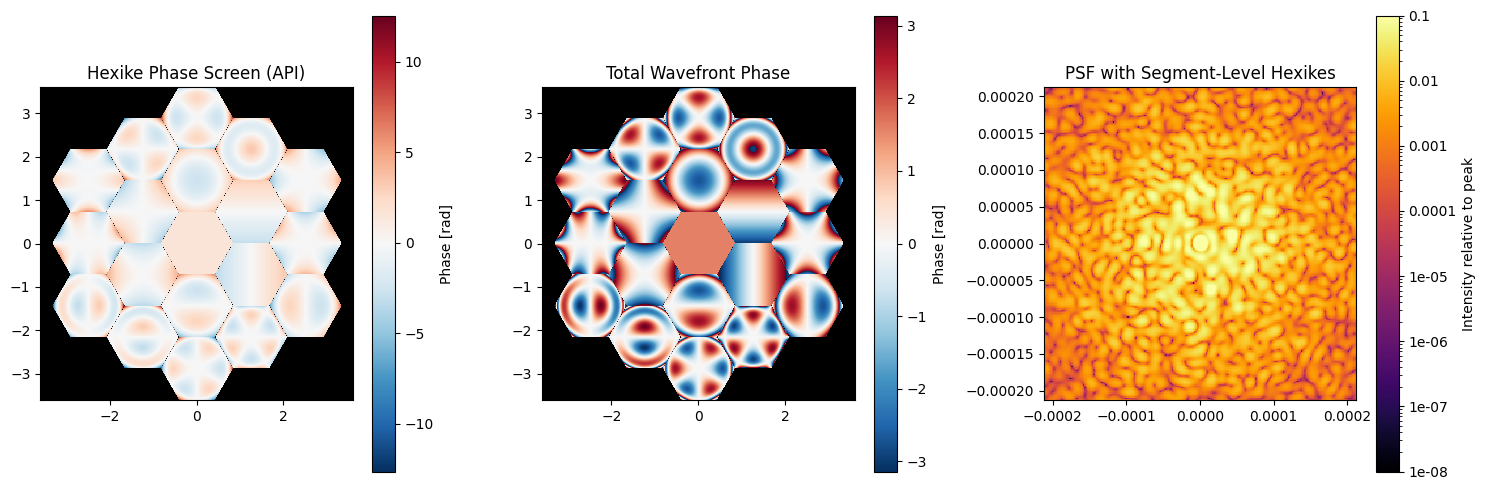


=== Zooming into Central Segment (Segment 0) ===


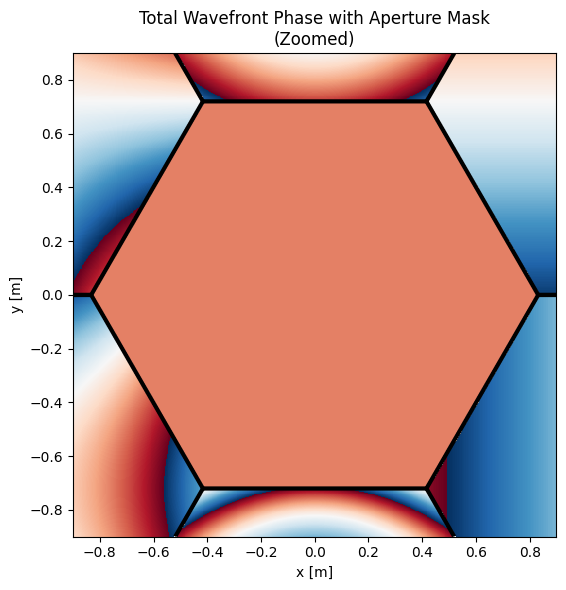

Zoom region: x=[-0.90, 0.90], y=[-0.90, 0.90]
Zoomed array shape: (512, 512)
Total aperture pixels in zoom: 261876

=== Verifying stored hexike coefficients ===
Number of segments with hexike aberrations: 19
Example - Segment 5 coefficients: {5: 100}


In [22]:
# Cell 4: Example 3 - Segment-level Hexike aberrations using new API

# Example 3: Segment-level Hexike aberrations
print("\n=== Example 3: Segment-Level Hexike Aberrations (New API) ===")

# Calculate segment centers for the API
segment_pitch = segment_flat_to_flat + gap_size
segment_centers = hcipy.make_hexagonal_grid(segment_pitch, num_rings, False)
mask = segment_centers.ones(dtype='bool')
segment_centers_grid = segment_centers.subset(mask)

# Create segmented mirror with hexike support using new API
hsm_api = hcipy.SegmentedDeformableMirror(
    segments,
    segment_diameter=segment_point_to_point,
    hexagon_angle=np.pi/2,  # Flat-top orientation
    segment_centers=segment_centers_grid,
    pupil_grid=pupil_grid
)

# Define segment-level hexike coefficients (in nm RMS)
# Apply different aberrations to different segments
segment_hexikes = {
    0: {0: 100}, 
    1: {1: 100},
    2: {2: 100},
    3: {3: 100},
    4: {4: 100},
    5: {5: 100},
    6: {6: 100},
    7: {7: 100},
    8: {8: 100},
    9: {9: 100},
    10: {10: 100},
    11: {11: 100},
    12: {12: 100},
    13: {13: 100},
    14: {14: 100},
    15: {15: 100},
    16: {16: 100},
    17: {17: 100},
    18: {18: 100}
}

# Apply hexike aberrations using the new API method
phase_screen_api = hsm_api.apply_segment_hexike_aberrations(segment_hexikes, wavelength)

# Create wavefront and apply segmented mirror (automatically includes hexike phase screen)
wf_api = hcipy.Wavefront(aper, wavelength)
wf_seg_hexike = hsm_api(wf_api)

# Propagate to PSF
psf_seg_hexike = prop(wf_seg_hexike)

# Visualization (matching original notebook)
plt.figure(figsize=(15, 5))

# Plot 1: Phase screen from API
plt.subplot(131)
plt.title('Hexike Phase Screen (API)')
hcipy.imshow_field(phase_screen_api, mask=aper, cmap='RdBu_r')
plt.colorbar(label='Phase [rad]')

# Plot 2: Total wavefront phase
plt.subplot(132)
plt.title('Total Wavefront Phase')
hcipy.imshow_field(np.angle(wf_seg_hexike.electric_field), mask=aper, cmap='RdBu_r')
plt.colorbar(label='Phase [rad]')

# Plot 3: PSF
plt.subplot(133)
plt.title('PSF with Segment-Level Hexikes')
hcipy.imshow_psf(psf_seg_hexike, normalization='peak')

plt.tight_layout()
plt.show()

# Zoom into the 0th segment (central segment) to verify Hexike modes
print("\n=== Zooming into Central Segment (Segment 0) ===")

plt.figure(figsize=(8, 6))

# Get the grid coordinates
x = pupil_grid.coords[0]
y = pupil_grid.coords[1]

# Define zoom region around the central segment (segment 0)
mode = 'full' # full, corner
if mode == 'full':
    zoom_xmin, zoom_xmax = -.9, 0.9
    zoom_ymin, zoom_ymax = -0.9, 0.9
elif mode == 'corner':
    zoom_xmin, zoom_xmax = -.9, -0.7
    zoom_ymin, zoom_ymax = -0.05, 0.05
else:
    raise ValueError(f"Invalid mode: {mode}")

# Mask for the zoomed region
zoom_mask = (x >= zoom_xmin) & (x <= zoom_xmax) & (y >= zoom_ymin) & (y <= zoom_ymax)

# Create a zoomed field for pixel-based visualization
zoom_indices = np.where(zoom_mask.reshape(pupil_grid.shape))
y_indices, x_indices = zoom_indices

# Get the bounds of the zoom region in grid indices
y_min, y_max = y_indices.min(), y_indices.max() + 1
x_min, x_max = x_indices.min(), x_indices.max() + 1

# Extract the zoomed phase data as 2D arrays
zoom_total_phase_2d = np.angle(wf_seg_hexike.electric_field).shaped[y_min:y_max, x_min:x_max]
zoom_aperture_2d = aper.shaped[y_min:y_max, x_min:x_max]

# Create extent for proper axis scaling
extent = (zoom_xmin, zoom_xmax, zoom_ymin, zoom_ymax)

# Create masked phase data where aperture is zero (black outside aperture)
zoom_phase_masked = np.where(zoom_aperture_2d == 1, zoom_total_phase_2d, np.nan)

# Plot: Total wavefront phase with aperture mask applied
plt.title('Total Wavefront Phase with Aperture Mask\n(Zoomed)')
plt.imshow(zoom_phase_masked, cmap='RdBu_r', interpolation='nearest', 
           extent=extent, origin='lower', aspect='equal')
# Superimpose aperture boundaries as contours
plt.contour(zoom_aperture_2d, levels=[0.5], colors='black', linewidths=2, 
           extent=extent, origin='lower')
plt.xlabel('x [m]')
plt.ylabel('y [m]')

plt.tight_layout()
plt.show()

# Additional analysis: Check if phase is applied to segment edges
print(f"Zoom region: x=[{zoom_xmin:.2f}, {zoom_xmax:.2f}], y=[{zoom_ymin:.2f}, {zoom_ymax:.2f}]")
print(f"Zoomed array shape: {zoom_total_phase_2d.shape}")
total_aperture_pixels = np.count_nonzero(zoom_aperture_2d)
print(f"Total aperture pixels in zoom: {total_aperture_pixels}")

# Verify hexike coefficients can be retrieved
print("\n=== Verifying stored hexike coefficients ===")
stored_coeffs = hsm_api.get_hexike_coefficients()
print(f"Number of segments with hexike aberrations: {len(stored_coeffs)}")
print(f"Example - Segment 5 coefficients: {stored_coeffs.get(5, {})}")

## Notebook Segment Testing

In [23]:
# Cell 4: Example 3 - Segment-level Zernike aberrations

# Example 3: Segment-level Zernike aberrations
print("\n=== Example 3: Segment-Level Zernike Aberrations ===")
hsm.flatten()  # Reset mirror first

# Define segment-level Zernike coefficients (in nm RMS)
# Apply different aberrations to different segments
segment_zernikes = {
    0: {0: 100},      # Segment 0: Zernike mode 0
    1: {1: 100},      # Segment 1: Zernike mode 1
    2: {2: 100},      # Segment 2: Zernike mode 2
    3: {3: 100},      # Segment 3: Zernike mode 3
    4: {4: 100},      # Segment 4: Zernike mode 4
    5: {5: 100},      # Segment 5: Zernike mode 5
    6: {6: 100},      # Segment 6: Zernike mode 6
    7: {7: 100},      # Segment 7: Zernike mode 7
    8: {8: 100},      # Segment 8: Zernike mode 8
    9: {9: 100},      # Segment 9: Zernike mode 9
    10: {10: 100},    # Segment 10: Zernike mode 10
    11: {11: 100},    # Segment 11: Zernike mode 11
    12: {12: 100},    # Segment 12: Zernike mode 12
    13: {13: 100},    # Segment 13: Zernike mode 13
    14: {14: 100},    # Segment 14: Zernike mode 14
    15: {15: 100},    # Segment 15: Zernike mode 15
    16: {16: 100},    # Segment 16: Zernike mode 16
    17: {17: 100},    # Segment 17: Zernike mode 17
    18: {18: 100},    # Segment 18: Zernike mode 18
}

# Generate PSF with segment-level Zernikes
psf_seg_zernike, wf_seg_zernike, phase_screens = generate_aberrated_psf(
    segment_zernikes=segment_zernikes, return_all=True)


=== Example 3: Segment-Level Zernike Aberrations ===


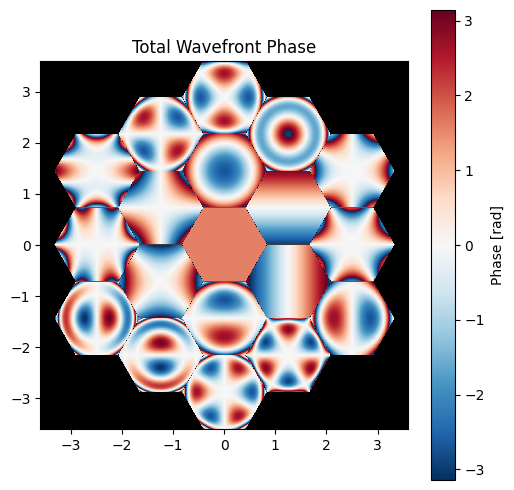

In [24]:
# Visualization
plt.figure(figsize=(15, 5))
# Plot 2: Total wavefront phase
plt.subplot(132)
plt.title('Total Wavefront Phase')
hcipy.imshow_field(np.angle(wf_seg_zernike.electric_field), mask=aper, cmap='RdBu_r')
plt.colorbar(label='Phase [rad]')

plt.tight_layout()
plt.show()


=== Zooming into Central Segment (Segment 0) ===


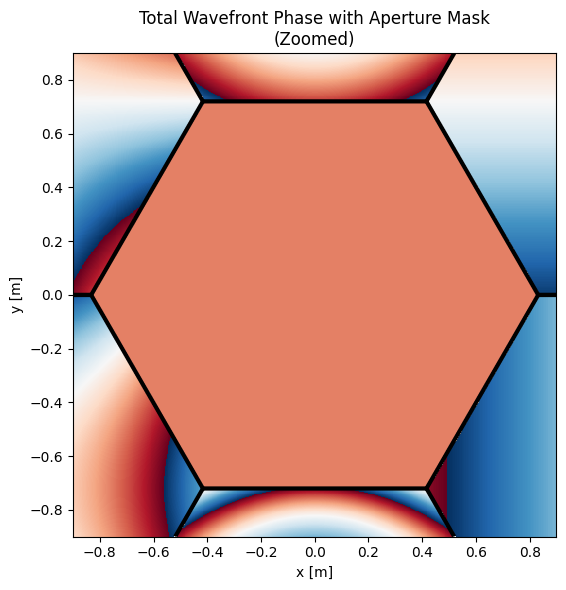

Zoom region: x=[-0.90, 0.90], y=[-0.90, 0.90]
Zoomed array shape: (512, 512)
Total aperture pixels in zoom: 261876


In [25]:
# Zoom into the 0th segment (central segment) to verify Zernike modes
print("\n=== Zooming into Central Segment (Segment 0) ===")

plt.figure(figsize=(8, 6))

# Get the grid coordinates
x = pupil_grid.coords[0]
y = pupil_grid.coords[1]

# Define zoom region around the central segment (segment 0)
# Adjust these coordinates based on your telescope geometry

mode = 'full' # full, corner
if mode == 'full':
    zoom_xmin, zoom_xmax = -.9, 0.9
    zoom_ymin, zoom_ymax = -0.9, 0.9
elif mode == 'corner':
    zoom_xmin, zoom_xmax = -.9, -0.7
    zoom_ymin, zoom_ymax = -0.05, 0.05
else:
    raise ValueError(f"Invalid mode: {mode}")

# Mask for the zoomed region
zoom_mask = (x >= zoom_xmin) & (x <= zoom_xmax) & (y >= zoom_ymin) & (y <= zoom_ymax)

# Create a zoomed field for pixel-based visualization
zoom_indices = np.where(zoom_mask.reshape(pupil_grid.shape))
y_indices, x_indices = zoom_indices

# Get the bounds of the zoom region in grid indices
y_min, y_max = y_indices.min(), y_indices.max() + 1
x_min, x_max = x_indices.min(), x_indices.max() + 1

# Extract the zoomed phase data as 2D arrays
zoom_total_phase_2d = np.angle(wf_seg_zernike.electric_field).shaped[y_min:y_max, x_min:x_max]
zoom_aperture_2d = aper.shaped[y_min:y_max, x_min:x_max]

# Create extent for proper axis scaling
extent = (zoom_xmin, zoom_xmax, zoom_ymin, zoom_ymax)

# Create masked phase data where aperture is zero (black outside aperture)
zoom_phase_masked = np.where(zoom_aperture_2d == 1, zoom_total_phase_2d, np.nan)

# Plot: Total wavefront phase with aperture mask applied
plt.title('Total Wavefront Phase with Aperture Mask\n(Zoomed)')
plt.imshow(zoom_phase_masked, cmap='RdBu_r', interpolation='nearest', 
           extent=extent, origin='lower', aspect='equal')
# Superimpose aperture boundaries as contours
plt.contour(zoom_aperture_2d, levels=[0.5], colors='black', linewidths=2, 
           extent=extent, origin='lower')
plt.xlabel('x [m]')
plt.ylabel('y [m]')

plt.tight_layout()
plt.show()

# Additional analysis: Check if phase is applied to segment edges
print(f"Zoom region: x=[{zoom_xmin:.2f}, {zoom_xmax:.2f}], y=[{zoom_ymin:.2f}, {zoom_ymax:.2f}]")
print(f"Zoomed array shape: {zoom_total_phase_2d.shape}")
total_aperture_pixels = np.count_nonzero(zoom_aperture_2d)
print(f"Total aperture pixels in zoom: {total_aperture_pixels}")


=== Example 4: Global Zernike Aberrations ===


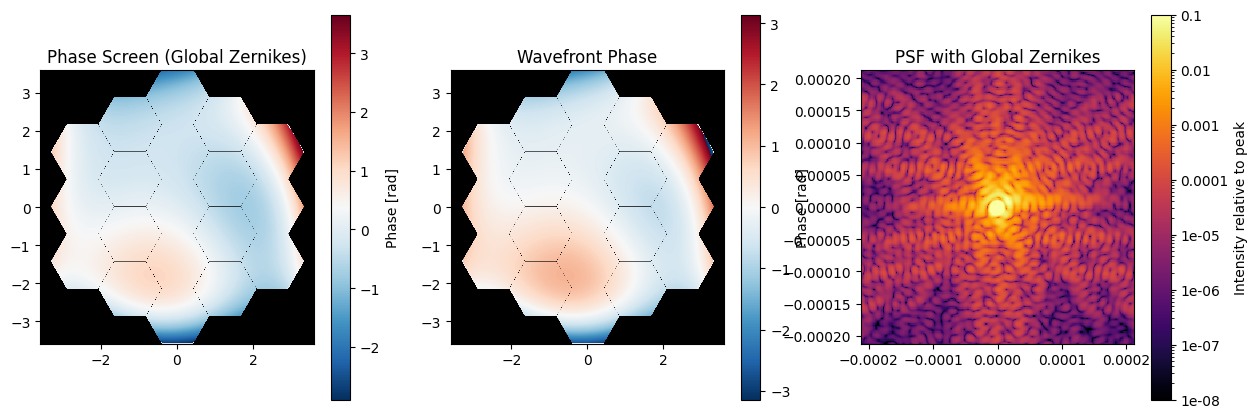

In [26]:
# Example 4: Global Zernike aberrations
print("\n=== Example 4: Global Zernike Aberrations ===")

# Define some Zernike coefficients (in nm RMS)
# Note: Zernike indexing starts at 0 (piston)
zernike_coeffs = {
    4: 20,   # Focus (Z4)
    5: 30,   # Astigmatism 0° (Z5)
    6: 20,   # Astigmatism 45° (Z6)
    7: 15,   # Coma X (Z7)
    8: 10,   # Coma Y (Z8)
    11: 25   # Spherical aberration (Z11)
}

psf_zernike, wf_zernike, phase_screens = generate_aberrated_psf(
    zernike_coeffs=zernike_coeffs, return_all=True)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title('Phase Screen (Global Zernikes)')
hcipy.imshow_field(phase_screens['global_zernikes'], mask=aper, cmap='RdBu_r')
plt.colorbar(label='Phase [rad]')

plt.subplot(132)
plt.title('Wavefront Phase')
hcipy.imshow_field(np.angle(wf_zernike.electric_field), mask=aper, cmap='RdBu_r')
plt.colorbar(label='Phase [rad]')

plt.subplot(133)
plt.title('PSF with Global Zernikes')
hcipy.imshow_psf(psf_zernike, normalization='peak')


=== Example 5: Combined Aberrations ===


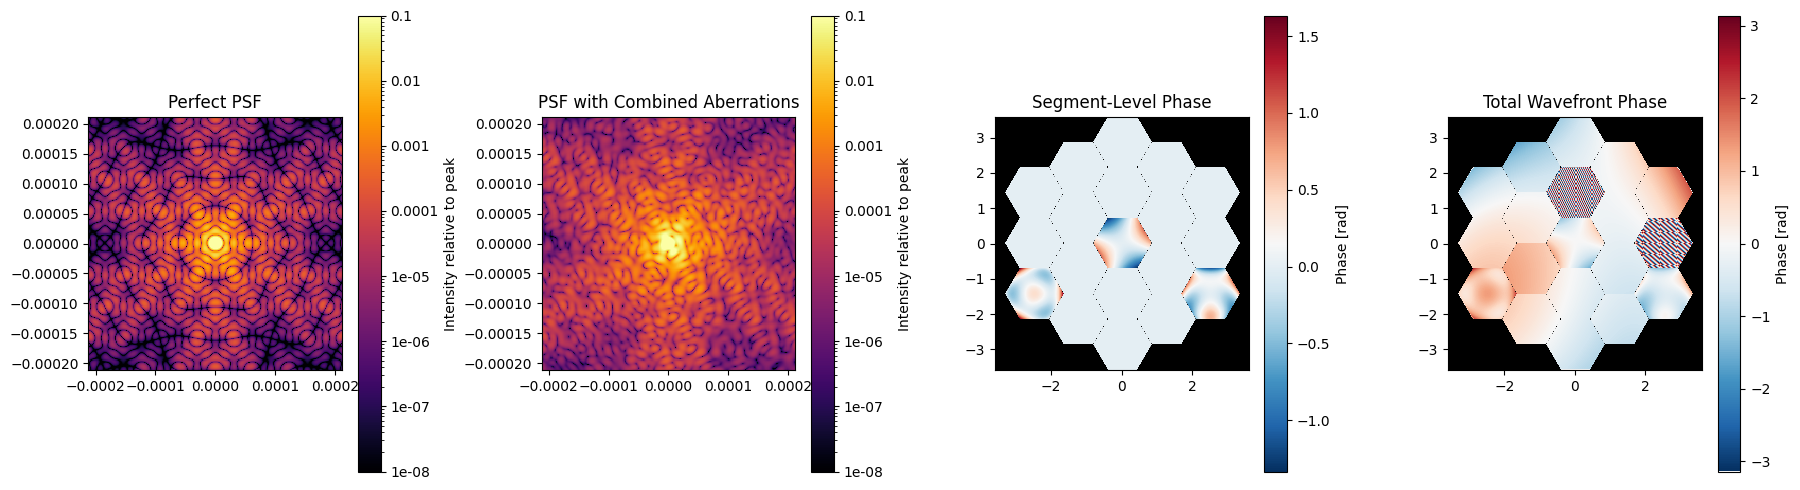

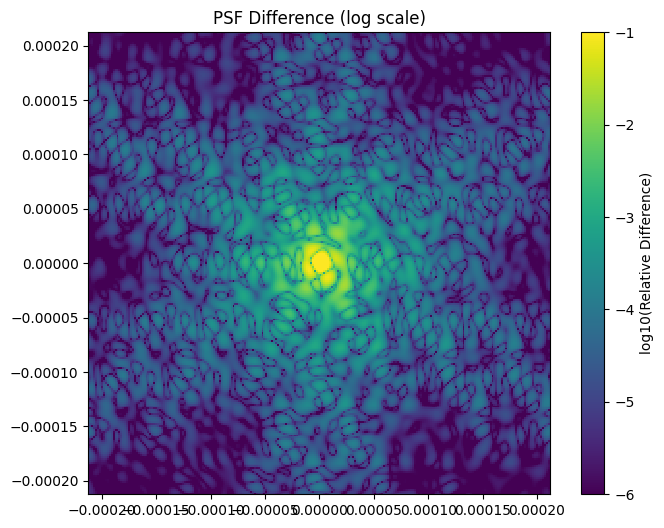


Aberrations Applied:
-------------------
Segment Pistons: {5: 30, 12: -20, 18: 15}
Segment Tip/Tilts: {3: (50, 25), 8: (-40, 60)}
Segment-Level Zernikes: {0: {4: 25, 5: 15}, 7: {8: 20, 11: 10}, 15: {9: 15, 10: 12}}
Global Zernikes: {4: 30, 5: 20, 7: 15}

Total RMS Wavefront Error: 0.0 nm


In [27]:
# Example 5: Combined aberrations
print("\n=== Example 5: Combined Aberrations ===")

# Define all four types of aberrations
combined_pistons = {5: 30, 12: -20, 18: 15}
combined_tiptilts = {3: (50, 25), 8: (-40, 60)}
combined_segment_zernikes = {
    0: {4: 25, 5: 15},      # Central segment: defocus and astigmatism
    7: {8: 20, 11: 10},     # Segment 7: coma and spherical
    15: {9: 15, 10: 12}     # Segment 15: trefoil modes
}
combined_global_zernikes = {4: 30, 5: 20, 7: 15}

# Generate PSF with all aberration types
psf_combined, wf_combined, phase_screens = generate_aberrated_psf(
    segment_pistons=combined_pistons,
    segment_tiptilts=combined_tiptilts,
    segment_zernikes=combined_segment_zernikes,
    zernike_coeffs=combined_global_zernikes,
    return_all=True
)

# Compare with perfect PSF
hsm.flatten()
wf_perfect = hcipy.Wavefront(aper, wavelength)
psf_perfect = prop(wf_perfect)

# Main comparison plot
plt.figure(figsize=(18, 5))

plt.subplot(141)
plt.title('Perfect PSF')
hcipy.imshow_psf(psf_perfect, normalization='peak')

plt.subplot(142)
plt.title('PSF with Combined Aberrations')
hcipy.imshow_psf(psf_combined, normalization='peak')

plt.subplot(143)
plt.title('Segment-Level Phase')
if 'segment_zernikes' in phase_screens:
    hcipy.imshow_field(phase_screens['segment_zernikes'], mask=aper, cmap='RdBu_r')
    plt.colorbar(label='Phase [rad]')

plt.subplot(144)
plt.title('Total Wavefront Phase')
hcipy.imshow_field(np.angle(wf_combined.electric_field), mask=aper, cmap='RdBu_r')
plt.colorbar(label='Phase [rad]')

plt.tight_layout()
plt.show()

# Show the difference
plt.figure(figsize=(8, 6))
plt.title('PSF Difference (log scale)')
diff = np.abs(psf_combined.intensity - psf_perfect.intensity)
hcipy.imshow_field(np.log10(diff / np.max(psf_perfect.intensity) + 1e-10), 
                   vmin=-6, vmax=-1, cmap='viridis')
plt.colorbar(label='log10(Relative Difference)')
plt.show()

# Print summary of all aberrations
print("\nAberrations Applied:")
print("-------------------")
print(f"Segment Pistons: {combined_pistons}")
print(f"Segment Tip/Tilts: {combined_tiptilts}")
print(f"Segment-Level Zernikes: {combined_segment_zernikes}")
print(f"Global Zernikes: {combined_global_zernikes}")

# Calculate total RMS
opd_map = hsm.surface * 2
valid_pixels = aper > 0.5
opd_valid = opd_map[valid_pixels]
opd_valid -= np.mean(opd_valid)
rms_nm = np.sqrt(np.mean(opd_valid**2)) * 1e9
print(f"\nTotal RMS Wavefront Error: {rms_nm:.1f} nm")

## Control level of segmented errors & grid search wavefront error

Initial RMS: 49020876.4711 nm, Scale factor: 0.000, Final RMS: 60.0000 nm
Target RMS: 60 nm
Actual RMS: 60.0000 nm


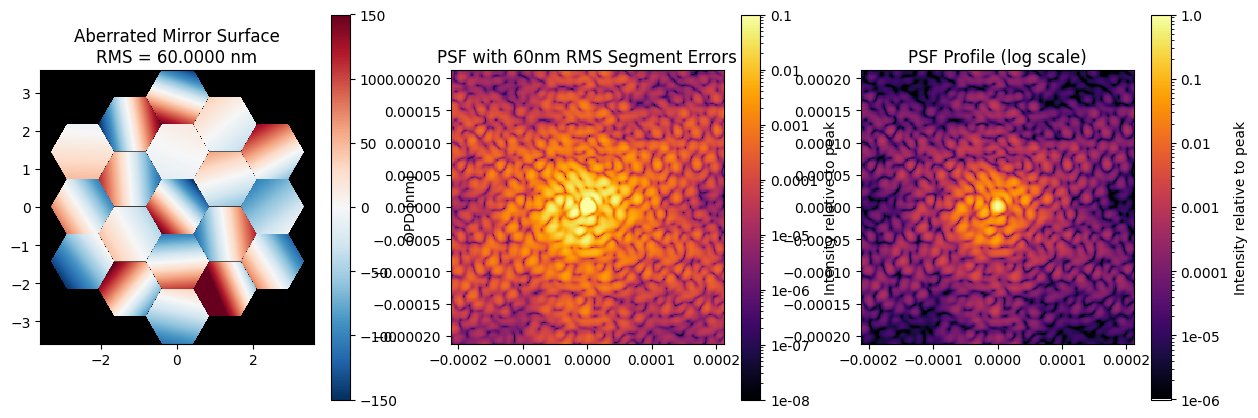


Segment aberration statistics:
Piston range: -0.0001 to 0.0001 nm
Tip range: -0.1927 to 0.1821 μrad
Tilt range: -0.1733 to 0.1039 μrad


In [28]:
# Function to generate random segment aberrations with controlled total RMS
def generate_random_segment_aberrations(target_rms_nm=60, piston_weight=0.5, tiptilt_weight=0.5):
    """Generate random piston/tip/tilt for all segments with specified total RMS."""
    np.random.seed(42)  # For reproducibility
    
    # Generate zero-mean random pistons and tip/tilts for all segments
    pistons_raw = np.random.randn(num_segments)
    pistons_raw -= np.mean(pistons_raw)
    tips_raw = np.random.randn(num_segments)
    tilts_raw = np.random.randn(num_segments)
    
    # Scale to desired RMS contributions
    piston_rms_target = target_rms_nm * np.sqrt(piston_weight)
    tiptilt_rms_target = target_rms_nm * np.sqrt(tiptilt_weight)
    
    pistons_nm = pistons_raw * (piston_rms_target / np.std(pistons_raw))
    
    # Convert tip/tilts to microradians (for small angles, RMS ~ angle * segment_radius / sqrt(3))
    segment_radius = segment_flat_to_flat / 2
    tiptilt_scale = tiptilt_rms_target / np.sqrt(np.var(tips_raw) + np.var(tilts_raw))
    tips_urad = tips_raw * tiptilt_scale * np.sqrt(3) / segment_radius * 1e3
    tilts_urad = tilts_raw * tiptilt_scale * np.sqrt(3) / segment_radius * 1e3
    
    return ({i: pistons_nm[i] for i in range(num_segments)}, 
            {i: (tips_urad[i], tilts_urad[i]) for i in range(num_segments)})

def calculate_wavefront_rms(hsm, aper, wavelength=wavelength):
    """Calculate the RMS wavefront error in nm."""
    opd_map = hsm.surface * 2  # Factor of 2 for reflection
    valid_pixels = aper > 0.5
    opd_valid = opd_map[valid_pixels]
    opd_valid -= np.mean(opd_valid)  # Remove piston
    return np.sqrt(np.mean(opd_valid**2)) * 1e9  # Convert to nm

def generate_calibrated_segment_aberrations(target_rms_nm=60, tolerance=1.0):
    """Generate segment aberrations that produce exactly the target RMS."""
    # Generate initial aberrations and measure actual RMS
    segment_pistons, segment_tiptilts = generate_random_segment_aberrations(target_rms_nm)
    
    hsm.flatten()
    apply_segment_pistons(hsm, segment_pistons)
    apply_segment_tiptilts(hsm, segment_tiptilts)
    actual_rms = calculate_wavefront_rms(hsm, aper)
    
    # Scale to match target and verify
    scale_factor = target_rms_nm / actual_rms
    segment_pistons = {k: v * scale_factor for k, v in segment_pistons.items()}
    segment_tiptilts = {k: (v[0] * scale_factor, v[1] * scale_factor) 
                       for k, v in segment_tiptilts.items()}
    
    hsm.flatten()
    apply_segment_pistons(hsm, segment_pistons)
    apply_segment_tiptilts(hsm, segment_tiptilts)
    final_rms = calculate_wavefront_rms(hsm, aper)
    
    print(f"Initial RMS: {actual_rms:.4f} nm, Scale factor: {scale_factor:.3f}, Final RMS: {final_rms:.4f} nm")
    return segment_pistons, segment_tiptilts

# Use the calibrated version
segment_pistons, segment_tiptilts = generate_calibrated_segment_aberrations(60)

# Apply them
hsm.flatten()
apply_segment_pistons(hsm, segment_pistons)
apply_segment_tiptilts(hsm, segment_tiptilts)

# Verify the RMS
actual_rms = calculate_wavefront_rms(hsm, aper)
print(f"Target RMS: 60 nm")
print(f"Actual RMS: {actual_rms:.4f} nm")

# Visualize the aberrated mirror
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.title(f'Aberrated Mirror Surface\nRMS = {actual_rms:.4f} nm')
hcipy.imshow_field(hsm.surface * 2 * 1e9, mask=aper, cmap='RdBu_r', vmin=-150, vmax=150)
plt.colorbar(label='OPD [nm]')

# Generate PSF
psf_60nm = generate_aberrated_psf(segment_pistons=segment_pistons, 
                                  segment_tiptilts=segment_tiptilts)

plt.subplot(132)
plt.title('PSF with 60nm RMS Segment Errors')
hcipy.imshow_psf(psf_60nm, normalization='peak')

plt.subplot(133)
plt.title('PSF Profile (log scale)')
hcipy.imshow_psf(psf_60nm, normalization='peak', vmin=1e-6, vmax=1)
plt.show()

# Show statistics
print("\nSegment aberration statistics:")
print(f"Piston range: {min(segment_pistons.values()):.4f} to {max(segment_pistons.values()):.4f} nm")
print(f"Tip range: {min([tt[0] for tt in segment_tiptilts.values()]):.4f} to {max([tt[0] for tt in segment_tiptilts.values()]):.4f} μrad")
print(f"Tilt range: {min([tt[1] for tt in segment_tiptilts.values()]):.4f} to {max([tt[1] for tt in segment_tiptilts.values()]):.4f} μrad")

## Calculate FWHM and Strehl Ratio of Generated PSFs

=== PSF Quality Measurements ===

Testing PSF quality measurements:

Perfect PSF:
  FWHM: 0.012 arcsec (12.1 mas)
  Strehl Ratio: 1.000

60nm RMS Aberrated PSF:
  FWHM: 0.013 arcsec (12.6 mas)
  Strehl Ratio: 0.454

Effect of defocus on PSF quality:
Amplitude (nm) | FWHM (mas) | Strehl Ratio
----------------------------------------
            0 |       12.6 |        0.454
           20 |       12.8 |        0.432
           40 |       13.8 |        0.362
           60 |       16.7 |        0.269
           80 |       24.6 |        0.182
          100 |       35.6 |        0.119


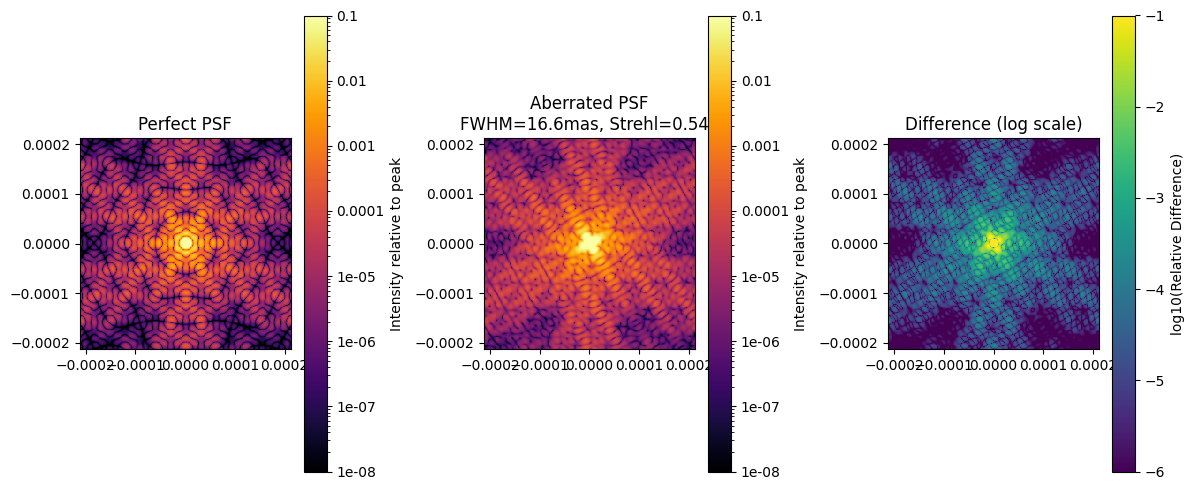

In [29]:
# PSF Quality Metrics: FWHM and Strehl Ratio
print("=== PSF Quality Measurements ===\n")

from scipy.optimize import curve_fit

def measure_fwhm(psf_field, pixel_scale=None):
    """
    Measure the Full Width at Half Maximum (FWHM) of a PSF using 2D Gaussian fitting.
    
    Parameters
    ----------
    psf_field : hcipy.Field
        The PSF field from HCIPy
    pixel_scale : float, optional
        Pixel scale in arcseconds/pixel. If None, returns FWHM in pixels.
    
    Returns
    -------
    fwhm : float
        FWHM (in arcsec if pixel_scale provided, else pixels)
    """
    # Get intensity data
    data = psf_field.intensity.shaped
    
    # Create coordinate grids
    y, x = np.mgrid[:data.shape[0], :data.shape[1]]
    
    # Find initial guess for center using peak location
    peak_idx = np.unravel_index(np.argmax(data), data.shape)
    y0_guess = peak_idx[0]
    x0_guess = peak_idx[1]
    
    # Define 2D Gaussian function
    # Note: We're fitting amplitude, center (x0, y0), widths (sigma_x, sigma_y), and background
    def gaussian_2d(coords, amplitude, x0, y0, sigma_x, sigma_y, background):
        x, y = coords
        return background + amplitude * np.exp(
            -((x - x0)**2 / (2 * sigma_x**2) + (y - y0)**2 / (2 * sigma_y**2))
        )
    
    # Initial parameter guesses
    amplitude_guess = data.max() - data.min()
    background_guess = np.percentile(data, 10)  # Use 10th percentile as background estimate
    sigma_guess = 3.0  # Initial guess for sigma in pixels
    
    initial_guess = [amplitude_guess, x0_guess, y0_guess, sigma_guess, sigma_guess, background_guess]
    
    # Prepare data for fitting - curve_fit needs flattened arrays
    xdata = np.vstack((x.ravel(), y.ravel()))
    ydata = data.ravel()
    
    # Fit the 2D Gaussian
    popt, _ = curve_fit(gaussian_2d, xdata, ydata, p0=initial_guess)
    
    # Extract the fitted parameters
    _, _, _, sigma_x, sigma_y, _ = popt
    
    # Convert sigma to FWHM
    # For a Gaussian: FWHM = 2 * sqrt(2 * ln(2)) * sigma ≈ 2.355 * sigma
    fwhm_factor = 2 * np.sqrt(2 * np.log(2))
    
    # Take geometric mean of x and y FWHM for circular equivalent
    fwhm_x = fwhm_factor * abs(sigma_x)
    fwhm_y = fwhm_factor * abs(sigma_y)
    fwhm_pixels = np.sqrt(fwhm_x * fwhm_y)
    
    # Convert to arcseconds if pixel scale provided
    if pixel_scale is not None:
        fwhm = fwhm_pixels * pixel_scale
    else:
        fwhm = fwhm_pixels
    
    return fwhm

def calculate_strehl_ratio(aberrated_psf, perfect_psf):
    """
    Calculate the Strehl ratio of an aberrated PSF.
    
    Parameters
    ----------
    aberrated_psf : hcipy.Field
        The aberrated PSF
    perfect_psf : hcipy.Field
        The perfect PSF
    
    Returns
    -------
    strehl_ratio : float
        The Strehl ratio (0 to 1)
    """
    # Get peak intensities
    aberrated_peak = np.max(aberrated_psf.intensity)
    perfect_peak = np.max(perfect_psf.intensity)
    
    # Strehl ratio is the ratio of peaks
    strehl_ratio = aberrated_peak / perfect_peak
    
    return min(strehl_ratio, 1.0)

# Test with examples
print("Testing PSF quality measurements:\n")

# 1. Perfect PSF
psf_perfect = generate_aberrated_psf()
pixel_scale = wavelength / pupil_diameter * 206264.8062471 / sampling  # arcsec/pixel
fwhm_perfect = measure_fwhm(psf_perfect, pixel_scale)
strehl_perfect = calculate_strehl_ratio(psf_perfect, psf_perfect)

print(f"Perfect PSF:")
print(f"  FWHM: {fwhm_perfect:.3f} arcsec ({fwhm_perfect*1000:.1f} mas)")
print(f"  Strehl Ratio: {strehl_perfect:.3f}\n")

# 2. PSF with 60nm RMS aberrations
if 'psf_60nm' in locals():
    fwhm_60nm = measure_fwhm(psf_60nm, pixel_scale)
    strehl_60nm = calculate_strehl_ratio(psf_60nm, psf_perfect)
    print(f"60nm RMS Aberrated PSF:")
    print(f"  FWHM: {fwhm_60nm:.3f} arcsec ({fwhm_60nm*1000:.1f} mas)")
    print(f"  Strehl Ratio: {strehl_60nm:.3f}\n")

# 3. Test with different aberration levels
print("Effect of defocus on PSF quality:")
print("Amplitude (nm) | FWHM (mas) | Strehl Ratio")
print("-" * 40)

for defocus_nm in [0, 20, 40, 60, 80, 100]:
    psf = generate_aberrated_psf(zernike_coeffs={4: defocus_nm}, segment_pistons=segment_pistons, segment_tiptilts=segment_tiptilts)
    fwhm = measure_fwhm(psf, pixel_scale)
    strehl = calculate_strehl_ratio(psf, psf_perfect)
    print(f"{defocus_nm:>13} | {fwhm*1000:>10.1f} | {strehl:>12.3f}")

# Simple visualization
plt.figure(figsize=(12, 5))

# Plot a perfect PSF
plt.subplot(131)
plt.title('Perfect PSF')
hcipy.imshow_psf(psf_perfect, normalization='peak')

# Plot an aberrated PSF
psf_aberrated = generate_aberrated_psf(zernike_coeffs={4: 50, 5: 30})
fwhm_aberrated = measure_fwhm(psf_aberrated, pixel_scale)
strehl_aberrated = calculate_strehl_ratio(psf_aberrated, psf_perfect)

plt.subplot(132)
plt.title(f'Aberrated PSF\nFWHM={fwhm_aberrated*1000:.1f}mas, Strehl={strehl_aberrated:.3f}')
hcipy.imshow_psf(psf_aberrated, normalization='peak')

# Plot the difference
plt.subplot(133)
plt.title('Difference (log scale)')
diff = np.abs(psf_aberrated.intensity - psf_perfect.intensity)
hcipy.imshow_field(np.log10(diff / np.max(psf_perfect.intensity) + 1e-10), 
                   vmin=-6, vmax=-1, cmap='viridis')
plt.colorbar(label='log10(Relative Difference)')

plt.tight_layout()
plt.show()

## Output Data Structure

=== Converting HCIPy PSFs to PyAutoLens Kernels ===



Initial RMS: 49020876.4711 nm, Scale factor: 0.000, Final RMS: 60.0000 nm




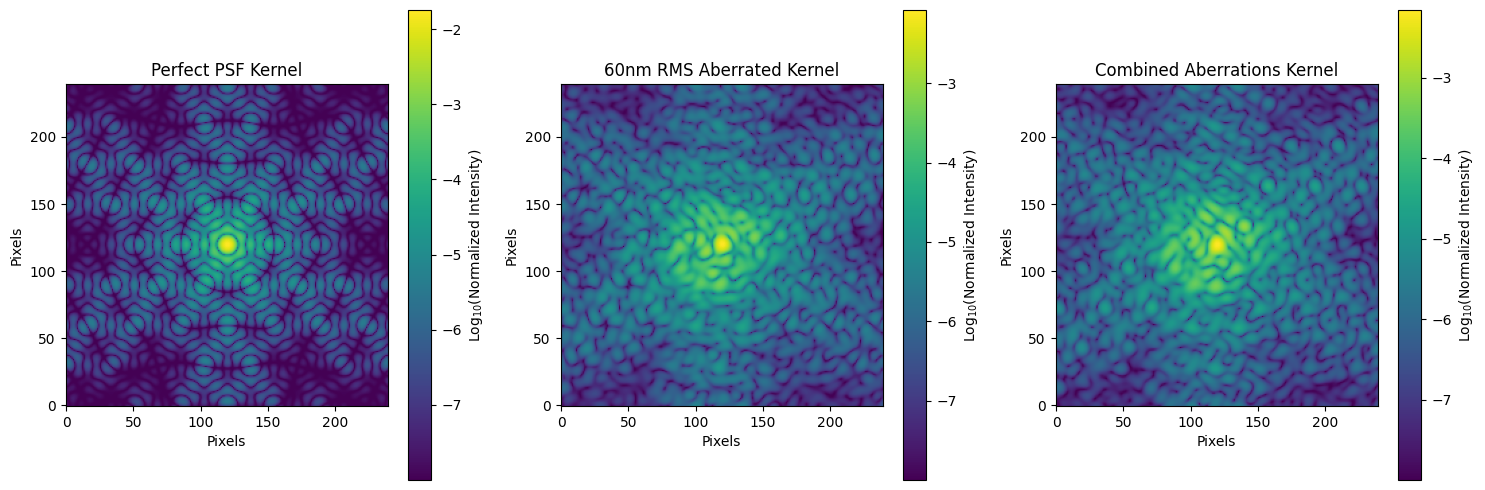


=== Kernel Properties ===

Perfect kernel - Total flux: 1.000000
60nm kernel - Total flux: 1.000000
Combined kernel - Total flux: 1.000000

=== Auto-sized Kernel ===


In [30]:
import autolens as al
import numpy as np

def hcipy_psf_to_kernel2d(
        psf_field: hcipy.Field,
        pixel_scale_arcsec: float | None = None,
        kernel_size: int | None = None,
        normalize: bool = True,
        threshold: float = 1e-6,
):
    """
    Convert an HCIPy PSF to a PyAutoLens Kernel2D.
    Returns
    -------
    kernel : al.Kernel2D
    """
    # 1. Pixel scale ----------------------------------------------------------
    if pixel_scale_arcsec is None:
        pixel_scale_rad = psf_field.grid.delta[0]          # spacings are uniform
        pixel_scale_arcsec = pixel_scale_rad * 206264.8062471    # rad → arcsec

    # 2. Intensity & cropping --------------------------------------------------
    psf = psf_field.intensity.shaped
    cy, cx = np.unravel_index(psf.argmax(), psf.shape)

    if kernel_size is None:
        mask = psf > psf.max() * threshold
        y_min, y_max = np.where(mask)[0].min(), np.where(mask)[0].max()
        x_min, x_max = np.where(mask)[1].min(), np.where(mask)[1].max()
        kernel_size = max(y_max - y_min + 1, x_max - x_min + 1)
        kernel_size += (kernel_size % 2 == 0)              # force odd
        kernel_size = min(kernel_size + 10, psf.shape[0])  # extra padding

    half = kernel_size // 2
    y0, y1 = max(0, cy - half), min(psf.shape[0], cy + half + 1)
    x0, x1 = max(0, cx - half), min(psf.shape[1], cx + half + 1)
    kernel_array = psf[y0:y1, x0:x1]

    # pad to square if crop touched an edge
    pad_y, pad_x = kernel_size - kernel_array.shape[0], kernel_size - kernel_array.shape[1]
    if pad_y or pad_x:
        kernel_array = np.pad(kernel_array, ((0, pad_y), (0, pad_x)))

    # 3. Normalise -------------------------------------------------------------
    if normalize:
        kernel_array /= kernel_array.sum()

    # 4. Build Kernel2D --------------------------------------------------------
    return al.Kernel2D.no_mask(values=kernel_array, pixel_scales=pixel_scale_arcsec, normalize=False)


# Example usage with the PSFs generated in the notebook
print("=== Converting HCIPy PSFs to PyAutoLens Kernels ===\n")

# 1. Convert the perfect PSF
kernel_perfect = hcipy_psf_to_kernel2d(psf_perfect)

# 2. Convert the 60nm RMS aberrated PSF
if 'psf_60nm' in locals():
    print("\n")
    kernel_60nm = hcipy_psf_to_kernel2d(psf_60nm)

# 3. Convert the 60nm RMS aberrated PSF with segment aberrations
segment_pistons, segment_tiptilts = generate_calibrated_segment_aberrations(60)
psf_combined_example = generate_aberrated_psf(
    segment_pistons=segment_pistons,
    segment_tiptilts=segment_tiptilts,
    zernike_coeffs={4: 30, 5: 20, 6: 10}
)

print("\n")
kernel_combined = hcipy_psf_to_kernel2d(psf_combined_example)

# Visualize the kernels
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.title('Perfect PSF Kernel')
plt.imshow(np.log10(kernel_perfect.native + 1e-8), cmap='viridis', origin='lower')
plt.colorbar(label='Log$_{10}$(Normalized Intensity)')
plt.xlabel('Pixels')
plt.ylabel('Pixels')

plt.subplot(132)
plt.title('60nm RMS Aberrated Kernel')
plt.imshow(np.log10(kernel_60nm.native + 1e-8), cmap='viridis', origin='lower')
plt.colorbar(label='Log$_{10}$(Normalized Intensity)')
plt.xlabel('Pixels')
plt.ylabel('Pixels')

plt.subplot(133)
plt.title('Combined Aberrations Kernel')
plt.imshow(np.log10(kernel_combined.native + 1e-8), cmap='viridis', origin='lower')
plt.colorbar(label='Log$_{10}$(Normalized Intensity)')
plt.xlabel('Pixels')
plt.ylabel('Pixels')

plt.tight_layout()
plt.show()

# Show kernel properties
print("\n=== Kernel Properties ===")
print(f"\nPerfect kernel - Total flux: {kernel_perfect.sum():.6f}")
print(f"60nm kernel - Total flux: {kernel_60nm.sum():.6f}")
print(f"Combined kernel - Total flux: {kernel_combined.sum():.6f}")

# Example: Create a kernel with automatic size detection
print("\n=== Auto-sized Kernel ===")
kernel_auto = hcipy_psf_to_kernel2d(psf_combined_example, kernel_size=None)